In [53]:
import torch
from torch import nn
import pathlib
from pathlib import Path
import zipfile
import shutil
import os
import random
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchmetrics import Accuracy, ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import torchinfo
from torchinfo import summary
from torchvision.utils import save_image


## Get data

In [2]:
data_path = Path('Foodvision_data')
data_path.mkdir(exist_ok=True,
                parents=True)

shutil.copy('/Users/navalmor/Desktop/pytorch/Food_images_classification/data/pizza_steak_sushi.zip',
            '/Users/navalmor/Desktop/PyTorch_Learning/computer vision/Foodvision_data')

with zipfile.ZipFile('/Users/navalmor/Desktop/PyTorch_Learning/computer vision/Foodvision_data/pizza_steak_sushi.zip', 'r') as z:
    z.extractall('/Users/navalmor/Desktop/PyTorch_Learning/computer vision/Foodvision_data/pizza_steak_sushi')

In [3]:
def get_data(dir):
    for dir_path, dir_name, file_name in os.walk(dir):
        print(f"There are {len(dir_name)} directories {dir_name} and {len(file_name)} images in {dir_path}")

get_data(data_path)

There are 1 directories ['pizza_steak_sushi'] and 2 images in Foodvision_data
There are 3 directories ['test', 'add', 'train'] and 0 images in Foodvision_data/pizza_steak_sushi
There are 3 directories ['steak', 'sushi', 'pizza'] and 0 images in Foodvision_data/pizza_steak_sushi/test
There are 0 directories [] and 19 images in Foodvision_data/pizza_steak_sushi/test/steak
There are 0 directories [] and 31 images in Foodvision_data/pizza_steak_sushi/test/sushi
There are 0 directories [] and 25 images in Foodvision_data/pizza_steak_sushi/test/pizza
There are 3 directories ['steak', 'sushi', 'pizza'] and 0 images in Foodvision_data/pizza_steak_sushi/add
There are 0 directories [] and 19 images in Foodvision_data/pizza_steak_sushi/add/steak
There are 0 directories [] and 31 images in Foodvision_data/pizza_steak_sushi/add/sushi
There are 0 directories [] and 25 images in Foodvision_data/pizza_steak_sushi/add/pizza
There are 3 directories ['steak', 'sushi', 'pizza'] and 0 images in Foodvision_

## Plot image

Image path: Foodvision_data/pizza_steak_sushi/train/pizza/667309.jpg
Image label: pizza
Image width: 512
Image height:384


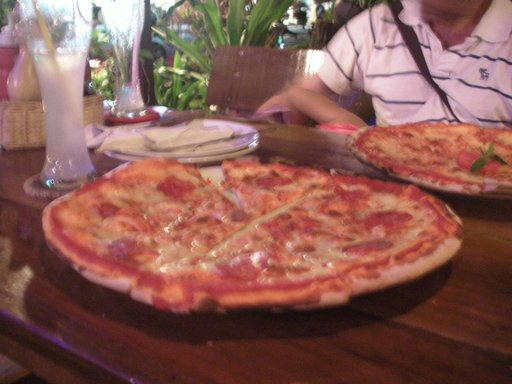

In [4]:
image_path = data_path/'pizza_steak_sushi'
image_path_list = list(image_path.glob('*/*/*.jpg'))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)
print(f"Image path: {random_image_path}")
print(f"Image label: {image_class}")
print(f"Image width: {img.width}\nImage height:{img.height}")
img

## Transform data

In [5]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    #transforms.TrivialAugmentWide(num_magnitude_bins=31),
    #transforms,.ConvertImageDtype(torch.uint8),
    transforms.AutoAugment(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    #transforms.TrivialAugmentWide(num_magnitude_bins=11),
    #transforms.ConvertImageDtype(torch.uint8),
    transforms.AutoAugment(),
    transforms.ToTensor()
])

## Create custom ImageLoader

In [6]:
def find_classes(dir):
    classes = sorted(i.name for i in os.scandir(dir))
    im_path = list(Path(dir).glob('*/*.jpg'))
    im_path_class = list(i.parent.name for i in im_path)
    if classes:
        class_to_idx = {class_name : j for j, class_name in enumerate(classes)}
    targets = []
    for i in im_path:
        lbl = i.parent.name
        targets.append(class_to_idx[lbl])
    return classes, class_to_idx, targets


class ImageFolderCustom(Dataset):
    def __init__(self,
                 dir : str,
                 data_transform = None):
         self.image_path = list(pathlib.Path(dir).glob('*/*.jpg'))
         self.data_transform = data_transform
         self.classes, self.class_to_idx, self.target = find_classes(dir)
    def load_image(self, index : int):
        img_path = self.image_path[index]
        return Image.open(img_path)
    
    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self, idx : int):
        img = self.load_image(idx)
        cls = self.image_path[idx].parent.name
        cls_idx = self.class_to_idx[cls]
        if self.data_transform:
            return self.data_transform(img), cls_idx
        return img, cls_idx
    
    def data(self):
        add = []
        for i in range(len(self.image_path)):
            add.append(self.__getitem__(i))
        return add

In [44]:
train_data = ImageFolderCustom(dir=Path('Foodvision_data/pizza_steak_sushi/train'),
                               data_transform=train_transform)

test_data_1 = ImageFolderCustom(dir=Path('Foodvision_data/pizza_steak_sushi/test'),
                                data_transform=test_transform)

test_data_2 = ImageFolderCustom(dir=Path('Foodvision_data/pizza_steak_sushi/add'),
                                data_transform=test_transform)
test_data = ConcatDataset([test_data_1, test_data_2])
len(test_data.datasets[0].target+test_data.datasets[1].target)

150

In [25]:
test_transform_add = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandAugment(),
    transforms.ToTensor()
])
test_data_add = ImageFolderCustom(dir=Path('Foodvision_data/pizza_steak_sushi/test'),
                                   data_transform=test_transform_add)


In [26]:
for num, (img, lbl) in enumerate(test_data_add.data()):
    if lbl == test_data_add.class_to_idx['pizza']:
        save_image(tensor=img,
                   fp=Path(f'Foodvision_data/pizza_steak_sushi/add/pizza/{num}.jpg'))
    if lbl == test_data_add.class_to_idx['steak']:
        save_image(tensor=img,
                   fp=Path(f'Foodvision_data/pizza_steak_sushi/add/steak/{num}.jpg'))
    if lbl == test_data_add.class_to_idx['sushi']:
        save_image(tensor=img,
                   fp=Path(f'Foodvision_data/pizza_steak_sushi/add/sushi/{num}.jpg'))

## Create dataloader

In [27]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             shuffle=False)

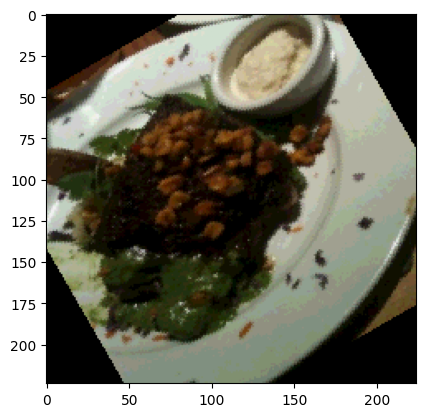

In [28]:
x, y = train_data[0]
plt.imshow(x.permute(1,2,0))

## Build model

In [29]:
class FoodVisionModel(nn.Module):
    def __init__(self,
                 in_features :int,
                 hidden_units :int,
                 out_features :int):
        super().__init__()

        self.conv_stack_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_features,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.Tanh(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_stack_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.Tanh(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.linear_classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*3136,
                      out_features=out_features)
        )

    def forward(self, X :torch.Tensor):
        #print(X.shape)
        X = self.conv_stack_1(X)
        #print(X.shape)
        X = self.conv_stack_2(X)
        #print(X.shape)
        X = self.linear_classifier(X)
        #print(X.shape)
        return(X)


In [30]:
model = FoodVisionModel(3,20,len(train_data.classes))

In [31]:
model(train_data[0][0].unsqueeze(0))

tensor([[-0.0057, -0.0376,  0.0450]], grad_fn=<AddmmBackward0>)

In [32]:
62720/20

3136.0

## Define train/eval function

In [33]:
torch.manual_seed(42)

def train_model(model :torch.nn.Module,
                train_dataloader :DataLoader,
                loss_fn :nn.functional,
                acc_fn :nn.functional,
                optimizer :torch.optim):
    model.train()
    train_loss = 0
    train_acc = 0
    for X,y in train_dataloader:
        train_logits = model(X)
        train_loss += loss_fn(train_logits, y)
        train_pred = torch.softmax(train_logits, dim=1).argmax(dim=1)
        train_acc += acc_fn(train_pred, y)
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    return train_loss, train_acc*100


def eval_model(model :nn.Module,
               test_dataloader :DataLoader,
               loss_fn :nn.functional,
               acc_fn :nn.functional):
    model.eval()
    with torch.inference_mode():
        test_loss = 0
        test_acc = 0
        for X,y in test_dataloader:
            test_logits = model(X)
            test_loss += loss_fn(test_logits, y)
            test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
            test_acc += acc_fn(test_pred, y)
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        return test_loss, test_acc*100

## Run train/test loop

In [56]:
loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy(task='multiclass',
                  num_classes=3)
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=0.001)
epochs = 50
epoch_values = []
train_loss_values = []
test_loss_values = []
for epoch in range(epochs):
    train_loss, train_acc = train_model(model=model,
                                        train_dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        acc_fn=acc_fn,
                                        optimizer=optimizer)
    test_loss, test_acc = eval_model(model=model,
                                     test_dataloader=test_dataloader,
                                     loss_fn=loss_fn,
                                     acc_fn=acc_fn)
    if epoch%1==0:
        print(f"Epoch : {epoch} | Train_loss : {train_loss :.3f} | Train_acc : {train_acc :.2f}% | Test_loss : {test_loss :.3f} | test_acc : {test_acc :.2f}%")
        epoch_values.append(epoch)
        train_loss_values.append(train_loss)
        test_loss_values.append(test_loss)

Epoch : 0 | Train_loss : 0.801 | Train_acc : 65.62% | Test_loss : 1.331 | test_acc : 42.33%
Epoch : 1 | Train_loss : 0.972 | Train_acc : 59.77% | Test_loss : 1.976 | test_acc : 34.66%
Epoch : 2 | Train_loss : 1.819 | Train_acc : 46.09% | Test_loss : 1.141 | test_acc : 43.47%
Epoch : 3 | Train_loss : 0.780 | Train_acc : 74.22% | Test_loss : 1.173 | test_acc : 44.55%
Epoch : 4 | Train_loss : 0.867 | Train_acc : 66.80% | Test_loss : 1.224 | test_acc : 39.20%
Epoch : 5 | Train_loss : 0.877 | Train_acc : 63.67% | Test_loss : 1.151 | test_acc : 42.44%
Epoch : 6 | Train_loss : 0.763 | Train_acc : 64.06% | Test_loss : 1.079 | test_acc : 45.68%
Epoch : 7 | Train_loss : 0.814 | Train_acc : 70.70% | Test_loss : 1.185 | test_acc : 43.47%
Epoch : 8 | Train_loss : 0.715 | Train_acc : 68.36% | Test_loss : 1.169 | test_acc : 39.03%
Epoch : 9 | Train_loss : 0.731 | Train_acc : 69.14% | Test_loss : 1.125 | test_acc : 49.20%
Epoch : 10 | Train_loss : 0.973 | Train_acc : 60.55% | Test_loss : 1.073 | test_

## Plot train/test loss

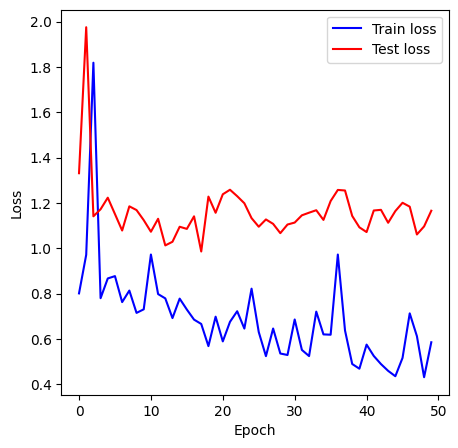

In [57]:
with torch.inference_mode():
    plt.figure(figsize=(5,5))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(epoch_values, train_loss_values, c='b', label='Train loss')
    plt.plot(epoch_values, test_loss_values, c='r', label='Test loss')
    plt.legend()

## Plot confusion metrics

In [58]:
def make_pred(model :nn.Module,
              data :torch.Tensor):
    pred = []
    for X, y in data:
        logit = model(X.unsqueeze(dim=0))
        prediction = logit.argmax()
        pred.append(prediction.item())
    return pred

test_pred = make_pred(model, test_data)

In [59]:
confusion_matrics = ConfusionMatrix(task='multiclass',
                                    num_classes=len(train_data.classes))
confusion_matrics_tensor = confusion_matrics(preds=torch.Tensor(test_pred),
                                             target=torch.Tensor(test_data.datasets[0].target+test_data.datasets[1].target))
confusion_matrics_tensor

tensor([[35,  7,  8],
        [14, 13, 11],
        [32, 10, 20]])

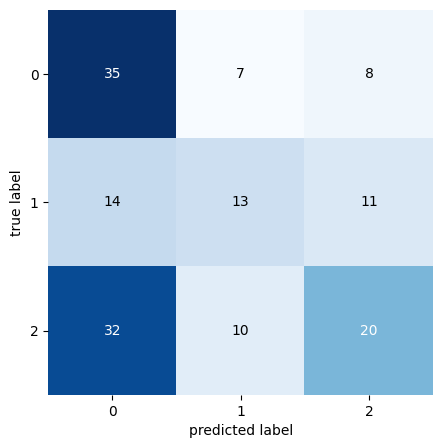

In [60]:
figure, axis = plot_confusion_matrix(
    confusion_matrics_tensor.numpy(),
    train_data.classes,
    figsize=(5,5)
)

In [61]:
summary(model, input_data=train_data[0][0].unsqueeze(0))

Layer (type:depth-idx)                   Output Shape              Param #
FoodVisionModel                          [1, 3]                    --
├─Sequential: 1-1                        [1, 20, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 20, 224, 224]         560
│    └─Tanh: 2-2                         [1, 20, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 20, 224, 224]         3,620
│    └─Tanh: 2-4                         [1, 20, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 20, 112, 112]         --
├─Sequential: 1-2                        [1, 20, 56, 56]           --
│    └─Conv2d: 2-6                       [1, 20, 112, 112]         3,620
│    └─Tanh: 2-7                         [1, 20, 112, 112]         --
│    └─Conv2d: 2-8                       [1, 20, 112, 112]         3,620
│    └─Tanh: 2-9                         [1, 20, 112, 112]         --
│    └─MaxPool2d: 2-10                   [1, 20, 56, 56]           --
├─Seq

In [62]:
torch.save(model, '/Users/navalmor/Desktop/PyTorch_Learning/computer vision/models/FoodvisionModel.pt')